### Import

In [1]:
from tqdm import tqdm; tqdm.pandas()
from collections import defaultdict
from IPython.display import clear_output

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import torch
from pytorch_model_summary import summary

from rawdata import RawData, Preprocess
from data import DataInfo, Dataset, collate_fn
from data import NoneScaler, LogScaler, CustomLabelEncoder

device = torch.device("cuda")

### Config

In [2]:
test_mode = False

# Raw data
is_prep_data_exist = True

# Data loader
MIN_MEANINGFUL_SEQ_LEN = 100
MAX_SEQ_LEN = 365
PRED_LEN = 100

modality_info = {
    "group": ["article_id", "sales_channel_id"],
    "target": ["sales"],
    "temporal": ["day", "dow", "month", "holiday", "price"],
}
processing_info = {
    "scaling_cols": {"sales": StandardScaler, "price": StandardScaler},
    "embedding_cols": ["day",  "dow", "month", "holiday"],
}

# Model
batch_size = 32
nhead = 4
dropout = 0.1
is_identical = False

d_model = {"encoder":64, "decoder":32}
d_ff = {"encoder":64, "decoder":32}
num_layers = {"encoder":2, "decoder":2}
remain_rto = {"target": 0.25, "temporal":0.25, "cat":0.25}

# Data

### Raw data

In [3]:
if test_mode:
    df_preprocessed = pd.read_parquet("src/df_preprocessed_test.parquet")
else:
    if not is_prep_data_exist:
        rawdata = RawData()
        df_trans, df_meta, df_holiday = rawdata.get_raw_data()
        preprocess = Preprocess(df_trans, df_meta, df_holiday)
        df_preprocessed = preprocess.main()
    else:
        df_preprocessed = pd.read_parquet("src/df_preprocessed.parquet")

### Dataset

In [4]:
df_train = df_preprocessed[(df_preprocessed["meaningful_size"] >= MIN_MEANINGFUL_SEQ_LEN) & (df_preprocessed["time_idx"] <= MAX_SEQ_LEN-1)]
df_valid = df_preprocessed[(df_preprocessed["meaningful_size"] >= MIN_MEANINGFUL_SEQ_LEN) & (df_preprocessed["time_idx"] <= MAX_SEQ_LEN-1 + PRED_LEN)]

data_info = DataInfo(modality_info, processing_info)

In [5]:
train_dataset = Dataset(df_train, data_info, remain_rto)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: collate_fn(x, data_info), pin_memory=True, num_workers=16, prefetch_factor=4)
# train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: collate_fn(x, data_info))

for data in train_dataloader:
    [print(key, val.shape) for key, val in data.items() if "scaler" not in key]
    break

100%|██████████| 29388/29388 [00:01<00:00, 19578.54it/s]


sales torch.Size([32, 365, 1])
sales_remain_idx torch.Size([32, 91])
sales_masked_idx torch.Size([32, 274])
sales_revert_idx torch.Size([32, 365])
sales_remain_padding_mask torch.Size([32, 91])
sales_masked_padding_mask torch.Size([32, 274])
sales_revert_padding_mask torch.Size([32, 365])
day torch.Size([32, 365])
day_remain_idx torch.Size([32, 91])
day_masked_idx torch.Size([32, 274])
day_revert_idx torch.Size([32, 365])
day_remain_padding_mask torch.Size([32, 91])
day_masked_padding_mask torch.Size([32, 274])
day_revert_padding_mask torch.Size([32, 365])
dow torch.Size([32, 365])
dow_remain_idx torch.Size([32, 91])
dow_masked_idx torch.Size([32, 274])
dow_revert_idx torch.Size([32, 365])
dow_remain_padding_mask torch.Size([32, 91])
dow_masked_padding_mask torch.Size([32, 274])
dow_revert_padding_mask torch.Size([32, 365])
month torch.Size([32, 365])
month_remain_idx torch.Size([32, 91])
month_masked_idx torch.Size([32, 274])
month_revert_idx torch.Size([32, 365])
month_remain_padding

# Train

### Model

In [6]:
import math
import copy

def get_positional_encoding(d_hidn, n_seq=1000):
    def cal_angle(position, i_hidn):
        return position / np.power(10000, 2 * (i_hidn // 2) / d_hidn)
    def get_posi_angle_vec(position):
        return [cal_angle(position, i_hidn) for i_hidn in range(d_hidn)]

    sinusoid_table = np.array([get_posi_angle_vec(i_seq) for i_seq in range(n_seq)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # even index sin 
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # odd index cos

    res = torch.tensor(sinusoid_table).to(torch.float32)
    return res

class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        super().__init__()
        self.dropout = torch.nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = torch.permute(x, (1,0,2))
        x = x + self.pe[:x.size(0)]
        x = torch.permute(x, (1,0,2))
        return self.dropout(x)

class FeedForward(torch.nn.Module):
    def __init__(self, d_model, d_ff, activation):
        super().__init__()
        self.linear1 = torch.nn.Linear(d_model, d_ff)
        self.linear2 = torch.nn.Linear(d_ff, d_model)
        self.dropout = torch.nn.Dropout()

        if activation == "relu":
            self.activation = torch.nn.ReLU()
        if activation == "gelu":
            self.activation = torch.nn.GELU()

    def forward(self, x):
        x = self.linear2(self.dropout(self.activation(self.linear1(x))))
        return self.dropout(x)

class MultiheadBlockAttention(torch.nn.Module):
    def __init__(self, d_model, num_heads, dropout):
        super().__init__()
        self.d_model, self.nhead = d_model, nhead
        
        self.q_linear = torch.nn.Linear(d_model, d_model)
        self.k_linear = torch.nn.Linear(d_model, d_model)
        self.v_linear = torch.nn.Linear(d_model, d_model)

        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, query, key, value):
        # Linear transformation
        Q = self.q_linear(query)
        K = self.k_linear(key)
        V = self.v_linear(value)

        # Split head
        batch_size, seq_len, _, d_model = Q.shape
        Q = Q.view(batch_size, seq_len, -1, self.nhead, d_model//self.nhead).permute(0,3,1,2,4)
        K = K.view(batch_size, seq_len, -1, self.nhead, d_model//self.nhead).permute(0,3,1,2,4)
        V = V.view(batch_size, seq_len, -1, self.nhead, d_model//self.nhead).permute(0,3,1,2,4)

        # Scaled dot product attention
        ### 1. Q·K^t
        QK = Q @ K.permute(0,1,2,4,3)

        ### 2. Softmax
        attn = torch.nn.functional.softmax(QK/math.sqrt(self.d_model//self.nhead), dim=-1)
        
        ### 3. Matmul V
        attn_output = attn @ V
        
        # Concat heads
        attn_output = attn_output.permute(0,2,3,1,4).reshape(batch_size, -1, seq_len, d_model)
        attn_output = attn_output.squeeze()

        return attn_output, attn

class Embedding(torch.nn.Module):
    def __init__(self, col, data_info, label_encoder_dict, d_model):
        super().__init__()
        self.col = col
        if col in data_info.processing_info["scaling_cols"]:
            self.embedding = torch.nn.Linear(1, d_model)
        elif col in data_info.processing_info["embedding_cols"]:
            num_cls = label_encoder_dict[col].get_num_cls()
            self.embedding = torch.nn.Embedding(num_cls, d_model)

    def forward(self, key, val):
        assert key == self.col

        return self.embedding(val)

class TemporalRemain(torch.nn.Module):
    def __init__(self, col, pos_enc):
        super().__init__()
        self.col = col
        self.pos_enc = pos_enc
    
    def forward(self, key, val, idx_dict):
        assert self.col == key

        # Positional encoding
        # pos_enc = self.pos_enc[:val.shape[1], :]
        val = self.pos_enc(val)
        # pos_enc = pos_enc.unsqueeze(0).repeat(val.shape[0], 1, 1)
        # val += pos_enc

        # Get remain data
        remain_idx = idx_dict[f"{key}_remain_idx"].unsqueeze(-1).repeat(1, 1, val.shape[-1])
        val = torch.gather(val, index=remain_idx, dim=1)

        return val

class ModalityEmbedding(torch.nn.Module):
    def __init__(self, col, modality, modality_embedding):
        super().__init__()
        self.col = col
        self.modality = modality[self.col]
        self.modality_embedding = modality_embedding
    
    def forward(self, key, val, device):
        assert self.col == key
        modality = torch.zeros(val.shape[1]).to(device) + self.modality
        modality = self.modality_embedding(modality.to(torch.int))

        val += modality
        return val

class Encoding(torch.nn.Module):
    def __init__(self, d_model, nhead, d_ff, dropout, activation, num_layers):
        super().__init__()
        self.encoder = torch.nn.TransformerEncoder(torch.nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=d_ff, dropout=dropout, batch_first=True, activation=activation, norm_first=True), num_layers)

    def forward(self, data_dict, padding_mask_dict, target_cols):
        concat_li, padding_mask_li = [], []
        for col in target_cols:
            concat_li.append(data_dict[col])
            padding_mask_li.append(padding_mask_dict[f"{col}_remain_padding_mask"])
        
        concat = torch.cat(concat_li, dim=1)
        padding_mask = torch.cat(padding_mask_li, dim=1)
        padding_mask = torch.where(padding_mask==1, 0, -torch.inf)
        assert concat.shape[1] == padding_mask.shape[1]

        encoding = self.encoder(concat, src_key_padding_mask=padding_mask)

        return encoding

class Split(torch.nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, target_cols, target_data, reference_dict):
        result_dict = {}
        start_idx = 0

        for col in target_cols:
            length = reference_dict[col].shape[1]
            result_dict[col] = target_data[:, start_idx:start_idx+length, :]
            start_idx += length
        
        assert start_idx == target_data.shape[1]

        return result_dict

class Revert(torch.nn.Module):
    def __init__(self, col, mask_token, pos_enc):
        super().__init__()
        self.col = col
        self.mask_token = mask_token
        self.pos_enc = pos_enc

    def forward(self, key, val, idx_dict, padding_mask_dict):
        assert self.col == key

        # Replace remain padding to mask token
        remain_padding_mask = padding_mask_dict[f"{key}_remain_padding_mask"].unsqueeze(-1).repeat(1, 1, val.shape[-1])
        val = torch.where(remain_padding_mask==1, val, self.mask_token)

        # Append mask token
        revert_idx = idx_dict[f"{key}_revert_idx"].unsqueeze(-1).repeat(1, 1, val.shape[-1])
        mask_token = self.mask_token.unsqueeze(0).repeat(val.shape[0], revert_idx.shape[1]-val.shape[1], 1)
        val = torch.cat([val, mask_token], dim=1)

        assert revert_idx.shape == val.shape

        # Apply revert
        val = torch.gather(val, index=revert_idx, dim=1)

        # Apply positional encoding
        # pos_enc = self.pos_enc[val.shape[1], :]
        val = self.pos_enc(val)
        # pos_enc = pos_enc.unsqueeze(0).repeat(val.shape[0], 1, 1)
        # val += pos_enc

        return val

class TemporalDecoder(torch.nn.Module):
    def __init__(self, col, d_model, nhead, d_ff, dropout, activation, num_layers):
        super().__init__()
        self.col = col
        self.layers = torch.nn.ModuleList([copy.deepcopy(TemporalDecoderLayer(d_model, nhead, d_ff, dropout, activation)) for _ in range(num_layers)])

    def forward(self, key, val, data_dict, padding_mask_dict, total_cols):
        assert self.col == key

        # Get tgt and memory
        tgt = val
        
        memory_li = []
        for col in total_cols:
            if col == key: continue
            else:
                memory_li.append(data_dict[col])
        memory = torch.stack(memory_li, dim=-2)

        # Apply decoder
        padding_mask = padding_mask_dict[f"{key}_revert_padding_mask"]
        padding_mask = torch.where(padding_mask==1, 0, -torch.inf)
        for mod in self.layers:
            tgt, self_attn_weight, cross_attn_weight = mod(tgt, memory, padding_mask)
        
        return tgt, self_attn_weight, cross_attn_weight
        
class __TemporalDecoderLayer(torch.nn.Module):
    def __init__(self, d_model, nhead, d_ff, dropout, activation):
        super().__init__()
        self.cross_attn = MultiheadBlockAttention(d_model, nhead, dropout)
        self.self_attn = torch.nn.MultiheadAttention(d_model, nhead, dropout, batch_first=True)

        self.norm1 = torch.nn.LayerNorm(d_model)
        self.norm2 = torch.nn.LayerNorm(d_model)
        self.norm3 = torch.nn.LayerNorm(d_model)
        self.norm4 = torch.nn.LayerNorm(d_model)

        self.dropout1 = torch.nn.Dropout(dropout)
        self.dropout2 = torch.nn.Dropout(dropout)

        # Feed forward
        if activation == "relu":
            self.activation = torch.nn.ReLU()
        if activation == "gelu":
            self.activation = torch.nn.GELU()
        
        self.linear_ff1 = torch.nn.Linear(d_model, d_ff)
        self.linear_ff2 = torch.nn.Linear(d_ff, d_model)
        self.dropout_ff1 = torch.nn.Dropout(dropout)
        self.dropout_ff2 = torch.nn.Dropout(dropout)

    
    def forward(self, tgt, memory, tgt_padding_mask):
        # cross attention
        x = tgt
        
        # cross_attn_output, cross_attn_weight = self._ca_block(self.norm1(x.unsqueeze(-2)), self.norm2(memory), self.norm2(memory))
        cross_attn_output, cross_attn_weight = self._ca_block(self.norm1(x.unsqueeze(-2)), memory, memory)
        x = x + cross_attn_output
        
        self_attn_output, self_attn_weight = self._sa_block(self.norm3(x), tgt_padding_mask)
        x = x + self_attn_output

        x = x + self._ff_block(self.norm4(x))

        return x, self_attn_weight, cross_attn_weight
    
    def _ca_block(self, query, key, value):
        x, attn_weight = self.cross_attn(query, key, value)
        return self.dropout1(x), attn_weight

    def _sa_block(self, src, padding_mask):
        x, attn_weight = self.self_attn(src,src,src,
                           key_padding_mask=padding_mask)
        return self.dropout2(x), attn_weight

    def _ff_block(self, x):
        x = self.linear_ff2(self.dropout_ff1(self.activation(self.linear_ff1(x))))
        return self.dropout_ff2(x)

class TemporalDecoderLayer(torch.nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout, activation):
        super().__init__()
        # self.cross_attn = torch.nn.MultiheadAttention(d_model, num_heads, dropout, batch_first=True)
        self.cross_attn = MultiheadBlockAttention(d_model, num_heads, dropout)
        self.mlp = torch.nn.Linear(d_model, d_model)
        self.mha = torch.nn.MultiheadAttention(d_model, num_heads, dropout, batch_first=True)
        self.ff = FeedForward(d_model, d_ff, activation)

        self.layernorm_tgt = torch.nn.LayerNorm(d_model)
        self.layernorm_mem = torch.nn.LayerNorm(d_model)

        self.layernorm1 = torch.nn.LayerNorm(d_model)
        self.layernorm2 = torch.nn.LayerNorm(d_model)
        self.layernorm3 = torch.nn.LayerNorm(d_model)

    def forward(self, tgt, memory, padding_mask):
        tgt = tgt.unsqueeze(-2)
        # memory = torch.stack(list(memory.values()), dim=-2)
        
        tgt = self.layernorm_tgt(tgt)
        memory = self.layernorm_mem(memory)
        
        cross_attn, cross_attn_weight = self.cross_attn(query=tgt, key=memory, value=memory)

        cross_attn = tgt.squeeze() + cross_attn
        
        cross_attn = self.layernorm1(cross_attn)
        self_attn, self_attn_weight = self.mha(cross_attn, cross_attn, cross_attn, key_padding_mask=padding_mask) # multiheadattention

        self_attn = self_attn + cross_attn

        # ff
        self_attn = self.layernorm2(self_attn)
        ff = self_attn + self.ff(self_attn)
        
        return ff, self_attn_weight, cross_attn_weight

class TemporalOutput(torch.nn.Module):
    def __init__(self, col, data_info, label_encoder_dict, d_model):
        super().__init__()
        self.col = col

        if col in data_info.processing_info["scaling_cols"]:
            self.output = torch.nn.Sequential(
                            torch.nn.Linear(d_model, d_model),
                            torch.nn.Linear(d_model, 1))
        
        elif col in data_info.processing_info["embedding_cols"]:
            num_cls = label_encoder_dict[col].get_num_cls()
            self.output = torch.nn.Sequential(
                            torch.nn.Linear(d_model, d_model),
                            torch.nn.Linear(d_model, num_cls))
    
    def forward(self, key, val):
        assert self.col == key

        return self.output(val)

1==1

True

In [7]:
class Transformer(torch.nn.Module):
    def __init__(self, data_info, label_encoder_dict,
                d_model, num_layers, nhead, d_ff, dropout, activation):
        super().__init__()
        self.data_info, self.label_encoder_dict = data_info, label_encoder_dict
        self.temporal_cols = self.data_info.modality_info["target"] + self.data_info.modality_info["temporal"]
        self.total_cols = self.temporal_cols + []

        # 1. Embedding
        self.embedding_dict = self.init_process(mod=Embedding, target_cols=self.total_cols, args=[self.data_info, self.label_encoder_dict, d_model["encoder"]])

        # 2. Remain mask
        # encoder_pos_enc = torch.nn.Parameter(get_positional_encoding(d_model["encoder"]), requires_grad=False)
        encoder_pos_enc = PositionalEncoding(d_model["encoder"], dropout)
        self.temporal_remain_dict = self.init_process(mod=TemporalRemain, target_cols=self.temporal_cols, args=[encoder_pos_enc])

        # 3. Modality embedding
        num_modality = len(self.total_cols)
        modality = {col:n for n, col in enumerate(self.total_cols)}
        encoder_modality_embedding = torch.nn.Embedding(num_modality, d_model["encoder"])
        self.encoder_modality_embedding_dict = self.init_process(mod=ModalityEmbedding, target_cols=self.total_cols, args=[modality, encoder_modality_embedding])

        # 4. Encoding
        self.encoding = Encoding(d_model["encoder"], nhead, d_ff["encoder"], dropout, activation, num_layers["encoder"])
        self.to_decoder_dims = torch.nn.Linear(d_model["encoder"], d_model["decoder"])

        # 5. Split
        self.split = Split()

        # 6. Revert
        mask_token = torch.nn.Parameter(torch.rand(1, d_model["decoder"]))
        # decoder_pos_enc = torch.nn.Parameter(get_positional_encoding(d_model["decoder"]), requires_grad=False)
        decoder_pos_enc = PositionalEncoding(d_model["decoder"], dropout)
        self.revert_dict = self.init_process(mod=Revert, target_cols=self.total_cols, args=[mask_token, decoder_pos_enc])

        # 7. Modality embedding
        # decoder_modality_embedding = torch.nn.Sequential(encoder_modality_embedding, torch.nn.Linear(d_model["encoder"], d_model["decoder"]))
        decoder_modality_embedding = torch.nn.Embedding(num_modality, d_model["decoder"])
        self.decoder_modality_embedding_dict = self.init_process(mod=ModalityEmbedding, target_cols=self.total_cols, args=[modality, decoder_modality_embedding])

        # 8. Decoding
        self.temporal_decoding = self.init_process(mod=TemporalDecoder, target_cols=self.temporal_cols, args=[d_model["decoder"], nhead, d_ff["decoder"], dropout, activation, num_layers["decoder"]])

        # 9. Output
        self.temporal_output = self.init_process(mod=TemporalOutput, target_cols=self.temporal_cols, args=[self.data_info, self.label_encoder_dict, d_model["decoder"]])
    
    def forward(self, data_input, remain_rto, device):
        data_dict, idx_dict, padding_mask_dict = self.to_gpu(data_input)

        # 1. Embedding
        embedding_dict = self.apply_process(data=data_dict, mod=self.embedding_dict, target_cols=self.total_cols)

        # 2. Remain mask
        temporal_remain_dict = self.apply_process(data=embedding_dict, mod=self.temporal_remain_dict, target_cols=self.temporal_cols, args=[idx_dict])
        
        # 3. Modality embedding
        encoder_modality_embedding_dict = self.apply_process(data=temporal_remain_dict, mod=self.encoder_modality_embedding_dict, target_cols=self.total_cols, args=[device])

        # 4. Encoding
        encoding = self.encoding(encoder_modality_embedding_dict, padding_mask_dict, self.total_cols)
        encoding = self.to_decoder_dims(encoding)

        # 5. Split
        temporal_encoding = self.split(self.total_cols, encoding, encoder_modality_embedding_dict)

        # 6. Revert
        revert_dict = self.apply_process(data=temporal_encoding, mod=self.revert_dict, target_cols=self.total_cols, args=[idx_dict, padding_mask_dict])

        # 7. Modality embedding
        decoder_modality_embedding_dict = self.apply_process(data=revert_dict, mod=self.decoder_modality_embedding_dict, target_cols=self.total_cols, args=[device])

        # 8. Decoding
        temporal_decoding_dict = self.apply_process(data=decoder_modality_embedding_dict, mod=self.temporal_decoding, target_cols=self.temporal_cols, args=[decoder_modality_embedding_dict, padding_mask_dict, self.total_cols])
        temporal_decoding_dict, self_attn_weight_dict, cross_attn_weight_dict = self.tidy_decoding(temporal_decoding_dict)

        # 9. Output
        temporal_output = self.apply_process(data=temporal_decoding_dict, mod=self.temporal_output, target_cols=self.temporal_cols)

        return temporal_output, self_attn_weight_dict, cross_attn_weight_dict, idx_dict, padding_mask_dict
    
    def to_gpu(self, data_input):
        data_dict, idx_dict, padding_mask_dict = {}, {}, {}
        for key, val in data_input.items():
            if key in self.total_cols:
                data_dict[key] = data_input[key].to(device)
            elif key.endswith("idx"):
                idx_dict[key] = data_input[key].to(device)
            elif key.endswith("padding_mask"):
                padding_mask_dict[key] = data_input[key].to(device)
            
        return data_dict, idx_dict, padding_mask_dict

    def init_process(self, mod, target_cols, args=[]):
        result_dict = {}
        for col in target_cols:
            result_dict[col] = mod(col, *args)
        
        return torch.nn.ModuleDict(result_dict)

    def apply_process(self, data, mod, target_cols, args=[]):
        result_dict = {}
        for col in target_cols:
            result_dict[col] = mod[col](col, data[col], *args)
        
        return result_dict

    def tidy_decoding(self, decoding_dict_input):
        decoding_dict, self_attn_weight_dict, cross_attn_weight_dict = {}, {}, {}
        for key, val in decoding_dict_input.items():
            decoding_dict[key], self_attn_weight_dict[key], cross_attn_weight_dict[key] = val

        return decoding_dict, self_attn_weight_dict, cross_attn_weight_dict

1==1

True

In [8]:
model = Transformer(data_info, train_dataset.label_encoder_dict,
                        d_model, num_layers, nhead, d_ff, dropout, "gelu")
model.to(device)
summary(model, data, remain_rto, device, show_parent_layers=True, print_summary=True)

---------------------------------------------------------------------------------------
   Parent Layers       Layer (type)        Output Shape         Param #     Tr. Param #
     Transformer         Encoding-1       [32, 546, 64]          50,432          50,432
     Transformer           Linear-2       [32, 546, 32]           2,080           2,080
     Transformer            Split-3                                   0               0
Total params: 52,512
Trainable params: 52,512
Non-trainable params: 0
---------------------------------------------------------------------------------------


'---------------------------------------------------------------------------------------\n   Parent Layers       Layer (type)        Output Shape         Param #     Tr. Param #\n=======================================================================================\n     Transformer         Encoding-1       [32, 546, 64]          50,432          50,432\n     Transformer           Linear-2       [32, 546, 32]           2,080           2,080\n     Transformer            Split-3                                   0               0\n=======================================================================================\nTotal params: 52,512\nTrainable params: 52,512\nNon-trainable params: 0\n---------------------------------------------------------------------------------------'

In [9]:
import warnings
warnings.filterwarnings("ignore")

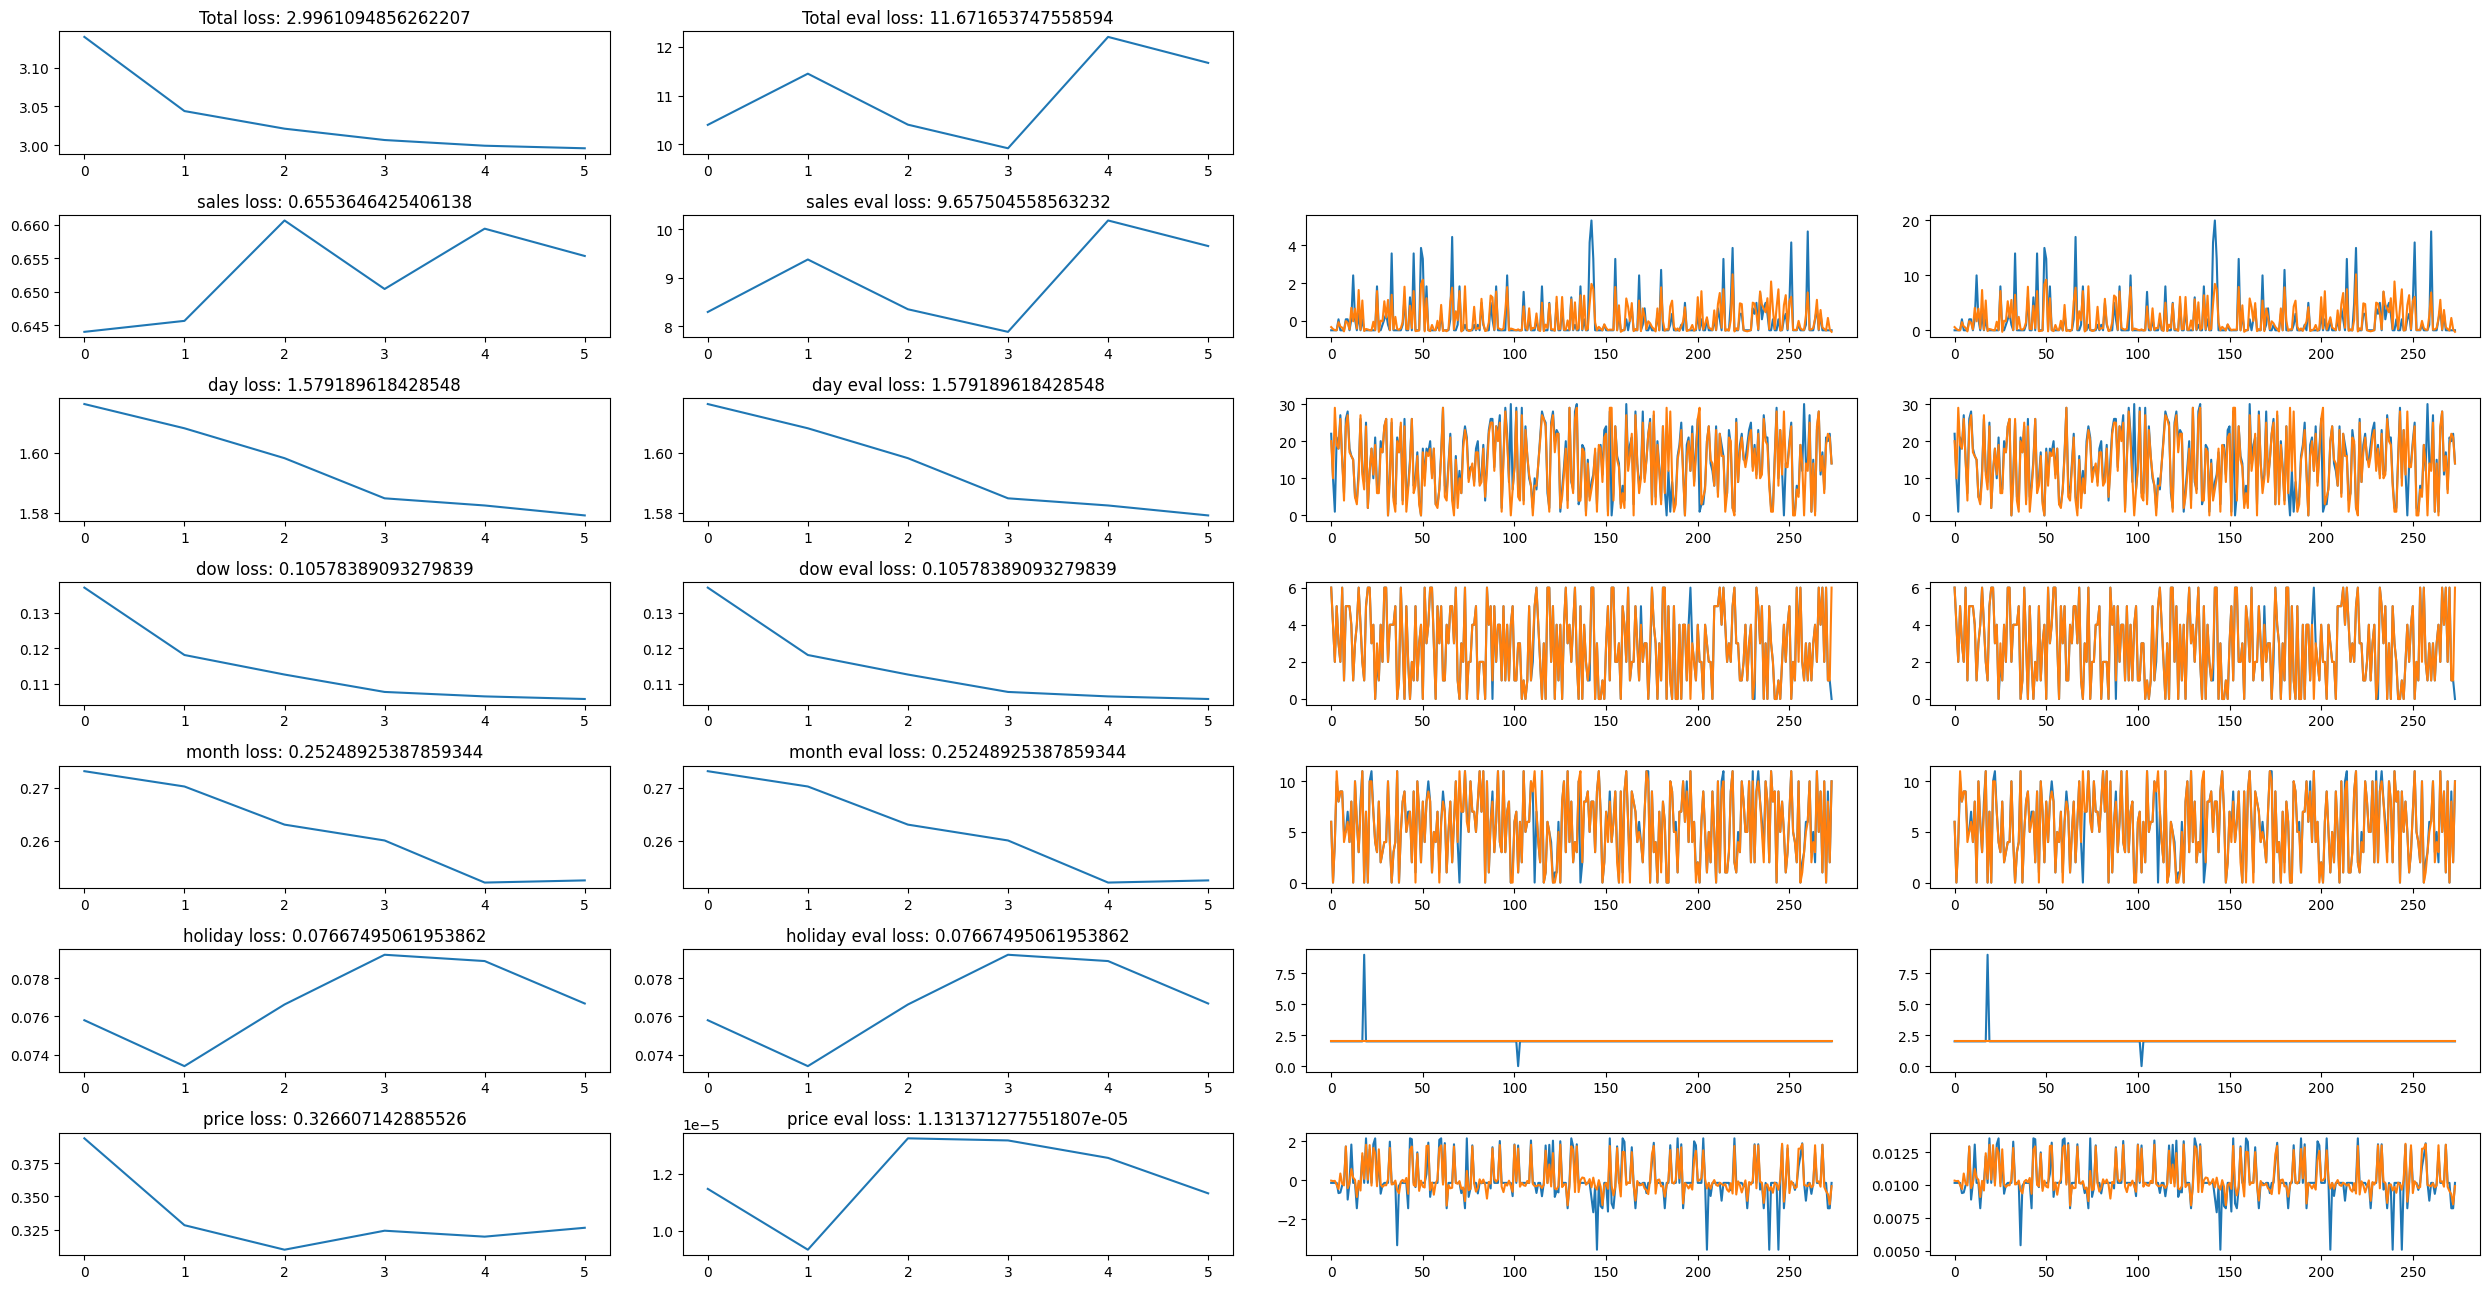

 11%|█         | 102/919 [01:32<14:37,  1.07s/it]

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)
mse_loss = torch.nn.MSELoss(reduction="none")
ce_loss = torch.nn.CrossEntropyLoss(reduction="none")

def get_temporal_loss(temporal_output, data, idx_dict, padding_mask_dict, data_info, inverse_scale=False):
    loss_dict = {}
    masked_pred_dict = {}
    masked_y_dict = {}
    for key, val in temporal_output.items():
        pred = val.squeeze()
        y = data[key].to(device).squeeze()

        if inverse_scale and key in data_info.processing_info["scaling_cols"]:
            pred = pred.detach().cpu()
            y = y.detach().cpu()

            new_pred, new_y = [], []
            scaler = data[f"{key}_scaler"]

            for i, s in enumerate(scaler):
                new_pred.append(torch.from_numpy(s.inverse_transform(pred[i].reshape(-1,1).numpy())))
                new_y.append(torch.from_numpy(s.inverse_transform(y[i].reshape(-1,1).numpy())))
            
            new_pred = torch.stack(new_pred, dim=0).squeeze().to(device)
            new_y = torch.stack(new_y, dim=0).squeeze().to(device)
            
            assert new_pred.shape == pred.shape and new_y.shape == y.shape

            pred, y = new_pred, new_y

        masked_idx = idx_dict[f"{key}_masked_idx"].squeeze()
        padding_mask = padding_mask_dict[f"{key}_masked_padding_mask"].squeeze()

        masked_y = torch.gather(y, index=masked_idx, dim=1)

        if key in data_info.processing_info["scaling_cols"]:
            masked_pred = torch.gather(pred, index=masked_idx, dim=1)
            loss = mse_loss(masked_pred, masked_y)
        elif key in data_info.processing_info["embedding_cols"]:
            masked_idx = masked_idx.unsqueeze(-1).repeat(1, 1, pred.shape[-1])
            masked_pred = torch.gather(pred, index=masked_idx, dim=1)

            masked_pred = masked_pred.reshape(-1, masked_pred.shape[-1])
            masked_y = masked_y.reshape(-1).to(torch.long)

            loss = ce_loss(masked_pred, masked_y).reshape(padding_mask.shape)

        loss = loss * padding_mask
        loss = sum(loss.view(-1)) / sum(padding_mask.view(-1))
        loss_dict[key] = loss

        masked_pred_dict[key] = masked_pred.reshape(padding_mask.shape[0], padding_mask.shape[1], -1)
        masked_y_dict[key] = masked_y.reshape(padding_mask.shape[0], padding_mask.shape[1], -1)

    return loss_dict, masked_pred_dict, masked_y_dict

def train(e):
    pbar = tqdm(train_dataloader)
    loss_li_dict, mean_loss_li_dict = defaultdict(list), defaultdict(list)
    eval_loss_li_dict, eval_mean_loss_li_dict = defaultdict(list), defaultdict(list)

    for n, data in enumerate(pbar):
        optimizer.zero_grad()
        model.train()
        temporal_output, self_attn_dict, cross_attn_dict, idx_dict, padding_mask_dict = model(data, remain_rto, device)
        
        temporal_loss_dict, masked_pred_dict, masked_y_dict = get_temporal_loss(temporal_output, data, idx_dict, padding_mask_dict, data_info)
        loss = torch.nansum(torch.stack(list(temporal_loss_dict.values())))
        temporal_loss_dict["total"] = loss
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            eval_temporal_loss_dict, eval_masked_pred_dict, eval_masked_y_dict = get_temporal_loss(temporal_output, data, idx_dict, padding_mask_dict, data_info, inverse_scale=True)
        eval_loss = torch.nansum(torch.stack(list(eval_temporal_loss_dict.values())))
        eval_temporal_loss_dict["total"] = eval_loss

        # Plot
        if n % 20 == 0:
            plt.figure(figsize=(25,13))
            clear_output(wait=True)
            nrows, ncols = 7, 4

            # Plot total loss
            plt.subplot(nrows, ncols, 1)
            total_loss = temporal_loss_dict["total"].item()
            loss_li_dict["total"].append(total_loss)
            mean_loss_li_dict["total"].append(np.array(loss_li_dict["total"]).mean())
            plt.plot(mean_loss_li_dict["total"])
            plt.title(f'Total loss: {mean_loss_li_dict["total"][-1]}')

            # Plot eval total loss
            plt.subplot(nrows, ncols, 2)
            eval_total_loss = eval_temporal_loss_dict["total"].item()
            eval_loss_li_dict["total"].append(eval_total_loss)
            eval_mean_loss_li_dict["total"].append(np.array(eval_loss_li_dict["total"]).mean())
            plt.plot(eval_mean_loss_li_dict["total"])
            plt.title(f'Total eval loss: {eval_mean_loss_li_dict["total"][-1]}')

            # Plot sample
            plot_idx = 5
            idx = 0
            for key, val in temporal_output.items():
                # Plot loss
                plt.subplot(nrows, ncols, plot_idx)
                sample_loss = temporal_loss_dict[key].item()
                loss_li_dict[key].append(sample_loss)
                mean_loss_li_dict[key].append(np.array(loss_li_dict[key]).mean())
                plt.plot(mean_loss_li_dict[key])
                plt.title(f"{key} loss: {mean_loss_li_dict[key][-1]}")
                plot_idx += 1

                # Plot eval loss
                plt.subplot(nrows, ncols, plot_idx)
                eval_sample_loss = eval_temporal_loss_dict[key].item()
                eval_loss_li_dict[key].append(eval_sample_loss)
                eval_mean_loss_li_dict[key].append(np.array(eval_loss_li_dict[key]).mean())
                plt.plot(eval_mean_loss_li_dict[key])
                plt.title(f"{key} eval loss: {eval_mean_loss_li_dict[key][-1]}")
                plot_idx += 1

                # Plot sample
                plt.subplot(nrows, ncols, plot_idx)
                sample_y = masked_y_dict[key].detach().cpu()
                sample_pred = masked_pred_dict[key].detach().cpu()
                if key in data_info.processing_info["embedding_cols"]:
                    sample_pred = torch.argmax(sample_pred, dim=-1)
                plt.plot(sample_y[idx], label="y")
                plt.plot(sample_pred[idx], label="pred")
                plot_idx += 1

                # Plot eval sample
                plt.subplot(nrows, ncols, plot_idx)
                eval_sample_y = eval_masked_y_dict[key].detach().cpu()
                eval_sample_pred = eval_masked_pred_dict[key].detach().cpu()
                if key in data_info.processing_info["embedding_cols"]:
                    eval_sample_pred = torch.argmax(eval_sample_pred, dim=-1)
                plt.plot(eval_sample_y[idx], label="y")
                plt.plot(eval_sample_pred[idx], label="pred")
                plot_idx += 1

            plt.tight_layout()
            plt.show()

epoch = 1
for e in range(epoch):
    train(e)
    scheduler.step()
    # raise